 # IEEE-CIS Fraud Detection

Vesta Corporation provided the dataset for this model. Vesta Corporation is the forerunner in guaranteed e-commerce payment solutions. Founded in 1995, Vesta pioneered the process of fully guaranteed card-not-present (CNP) payment transactions for the telecommunications industry. Since then, Vesta has firmly expanded data science and machine learning capabilities across the globe and solidified its position as the leader in guaranteed ecommerce payments. Today, Vesta guarantees more than $18B in transactions annually. 

Problem: Binary classification with a heavy dataset imbalance

## Objective: Detect fraud in Transactions

### Data:  
  
``isFraud`` is the binary that denotes whether a transaction is fraud or not and this is the dependent variable to be modeled for  

Data is broken into two files ***identity*** and ***transaction***, these can be join by the ``TransactioID``  
  
***Identity Categorical Features***
* DeviceType
* DeviceInfo
* id_12-id_38
  
***Transaction Categorical Features***
* Product CD
* emaildomain
* card1-card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1-M9

The ``TransactionDT`` feature is a timedelta from a given reference datetime (not an actual timestamp).


## Import Required Modules

In [27]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [411]:
# Functions

def detect_outlier(data):
    outliers=[]
    threshold=3
    mean = np.mean(data)
    std = np.std(data)
    
    for value in data:
        z_score = (value-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(value)
    return outliers

def distribution_fraud_percent(df, feature, bins):
    fig, ax1 = plt.subplots(figsize=(20, 5)) 

    (n1, bins1, patches1) = plt.hist(df.sort_values(feature)[feature], color='tab:green', bins=bins, alpha=0.5)
    (n2, bins2, patches2) = plt.hist(df.loc[df['isFraud']==1].sort_values(feature)[feature], bins=bins)
    heights1 = pd.Series(n1)
    heights2 = pd.Series(n2)
    heights = pd.concat([heights1, heights2], axis=1)
    heights['percent_fraud'] = (heights[1] / (heights[0] + heights[1]))*100
    center = (bins1[1] - bins1[0])/2
    heights['bins'] = (bins1[:-1] + center)

    ax1.set_title(f'{feature} Distribution')
    ax1.set_xlabel(f'{feature}') 
    ax1.set_ylabel('Count', color = 'tab:green') 
    ax1.hist(train.sort_values(feature)[feature], bins=bins, color='tab:green', alpha=0.5)
    ax1.tick_params(axis ='y', labelcolor = 'tab:green') 

    ax2 = ax1.twinx() 

    color = 'tab:red'
    ax2.set_ylabel('%Fraud', color = 'tab:red') 
    ax2.plot(heights['bins'], heights['percent_fraud'], color = 'tab:red', marker='o') 
    ax2.tick_params(axis ='y', labelcolor = 'tab:red')
    
    plt.show()
    
def cat_fraud_percent(df, feature):
    cat_size = df.groupby(feature).size()
    cat_fraud_size = df.loc[df['isFraud']==1].groupby(feature).size()

    cat_fraud_size = pd.DataFrame(cat_fraud_size)
    cat_fraud_size = cat_fraud_size.rename(columns={0: 'count_fraud'})

    cat_size = pd.DataFrame(cat_size)
    cat_size = cat_size.rename(columns={0: 'count'})

    df_merge = cat_size.merge(cat_fraud_size, how='outer', left_index=True, right_index=True)
    df_merge = df_merge.fillna(0.0)
    df_merge['percent_fraud'] = \
        (df_merge['count_fraud'] / (df_merge['count_fraud'] + df_merge['count']))*100

    fig, ax1 = plt.subplots(figsize=(20, 7))

    sns.barplot(x=df_merge.index, y=df_merge['count'], alpha=0.5, ax=ax1)
    ax1.tick_params(labelrotation=90)

    ax1.set_title(f'{feature}')

    ax2 = ax1.twinx()

    sns.lineplot(x=df_merge.index, y=df_merge['percent_fraud'], marker='o', ax=ax2)
    ax2.tick_params(labelrotation=90)
    
    plt.show()

## Load the Dataset

In [14]:
FOLDER_PATH = 'ieee-fraud-detection'
train_identity = pd.read_csv(f'{FOLDER_PATH}/train_identity.csv')
train_transaction = pd.read_csv(f'{FOLDER_PATH}/train_transaction.csv')
test_identity = pd.read_csv(f'{FOLDER_PATH}/test_identity.csv')
test_transaction = pd.read_csv(f'{FOLDER_PATH}/test_transaction.csv')

In [9]:
# merge the testing and training data
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [10]:
print(f'Transaction df shape: {train_transaction.shape}')
train_transaction.head()

Transaction df shape: (590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
print(f'Identity df shape: {train_identity.shape}')
train_identity.head()

Identity df shape: (144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [15]:
del train_identity, train_transaction, test_identity, test_transaction

## Exploratory Data Analysis

In [16]:
print(f'Train Columns w/ missing data: {train.isna().any().sum()}')

Train Columns w/ missing data: 414


In [20]:
missing_values = train.isnull().sum()
print(missing_values[:15])

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
dtype: int64


In [19]:
total_cells = np.product(train.shape)
missing_count = missing_values.sum()
print(f'{total_cells/missing_count: .2f}% mising data')

 2.22% mising data


In [21]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [23]:
fraud_count = pd.DataFrame(train.isFraud.value_counts())
fraud_count = fraud_count.reset_index()
print(fraud_count)

   index  isFraud
0      0   569877
1      1    20663


<Figure size 1152x432 with 0 Axes>

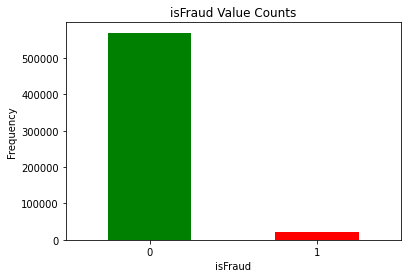

In [24]:
plt.figure(figsize=(16,6))
fraud_count.plot(x='index', y='isFraud', kind='bar', legend=False, color=['green', 'red'], rot=0)
plt.xlabel('isFraud')
plt.ylabel('Frequency')
plt.title('isFraud Value Counts')
plt.show()

In [25]:
train.TransactionAmt.describe()

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

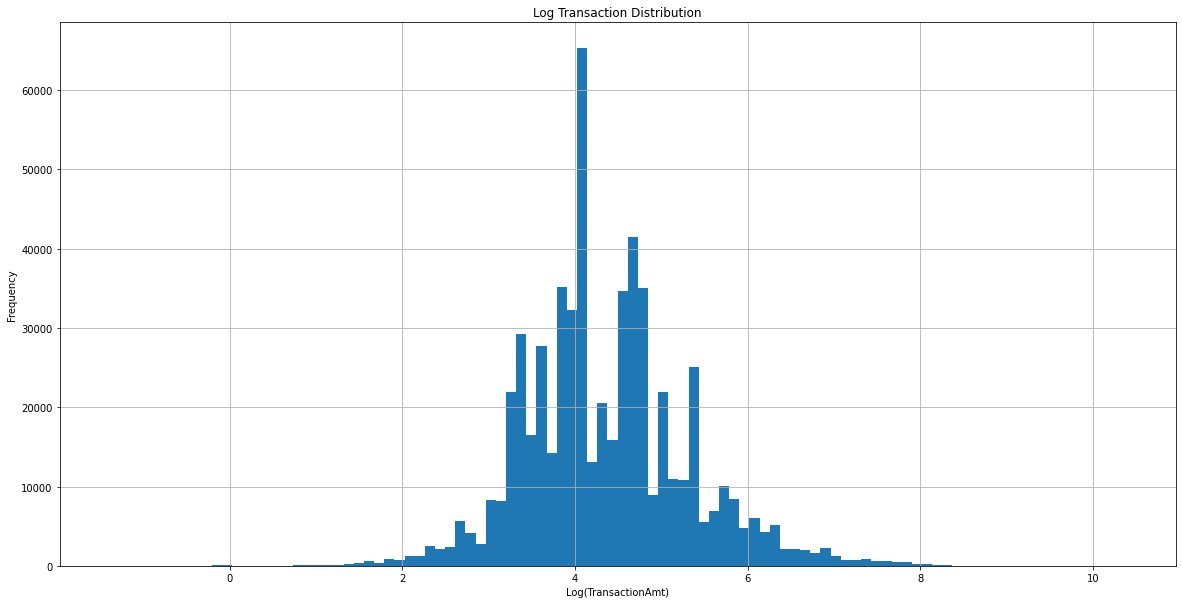

In [78]:
plt.figure(figsize=(20,10))
train['log_trans_amt'] = np.log(train['TransactionAmt'])
train['log_trans_amt'].hist(bins=100)
plt.xlabel('Log(TransactionAmt)')
plt.ylabel('Frequency')
plt.title('Log Transaction Distribution')

plt.show()

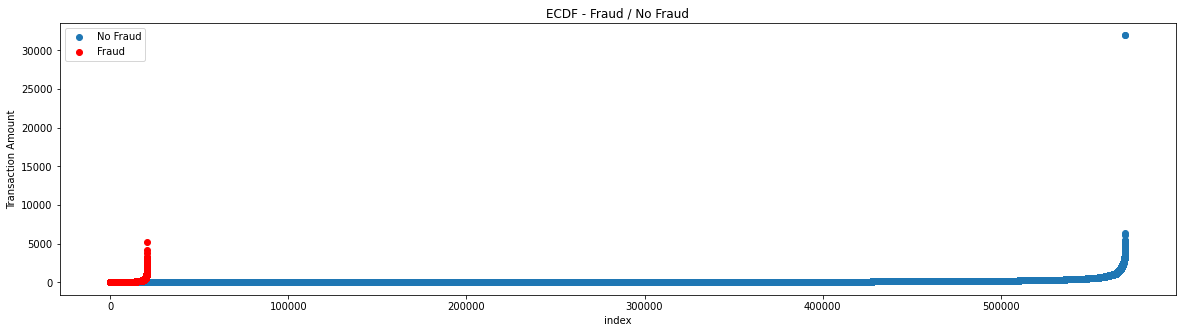

In [43]:
plt.figure(figsize=(20,5))
plt.scatter(train.loc[train['isFraud'] == 0].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 0][['TransactionAmt']].sort_values('TransactionAmt'), label='No Fraud')
plt.scatter(train.loc[train['isFraud'] == 1].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 1][['TransactionAmt']].sort_values('TransactionAmt'), color='red', label = 'Fraud')
plt.xlabel('index')
plt.ylabel('Transaction Amount')
plt.title('ECDF - Fraud / No Fraud')
plt.legend()
plt.show()

Text(0.5, 1.0, 'ECDF - Fraud')

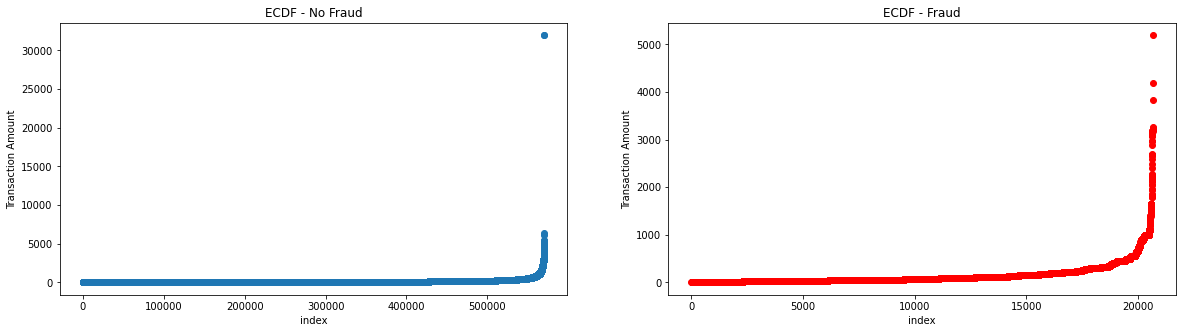

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

ax1.scatter(train.loc[train['isFraud'] == 0].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 0][['TransactionAmt']].sort_values('TransactionAmt'), label='No Fraud')
ax1.set_xlabel('index')
ax1.set_ylabel('Transaction Amount')
ax1.set_title('ECDF - No Fraud')

ax2.scatter(train.loc[train['isFraud'] == 1].sort_values('TransactionAmt').reset_index().index, \
         train.loc[train['isFraud'] == 1][['TransactionAmt']].sort_values('TransactionAmt'), color='red', label = 'Fraud')
ax2.set_xlabel('index')
ax2.set_ylabel('Transaction Amount')
ax2.set_title('ECDF - Fraud')

### Quantiles of Fraud and No Fraud Transactions

In [49]:
print('Quantiles of Fraud')
print(train.loc[train['isFraud'] == 1]['TransactionAmt'].quantile([0.01, 0.1, 0.24, 0.5, 0.75, 0.9]).reset_index())

Quantiles of Fraud
   index  TransactionAmt
0   0.01         6.74096
1   0.10        18.93600
2   0.24        34.00000
3   0.50        75.00000
4   0.75       161.00000
5   0.90       335.00000


In [50]:
print('Quantiles of No Fraud')
print(train.loc[train['isFraud'] == 0]['TransactionAmt'].quantile([0.01, 0.1, 0.24, 0.5, 0.75, 0.9]).reset_index())

Quantiles of No Fraud
   index  TransactionAmt
0   0.01         9.51288
1   0.10        26.31000
2   0.24        40.95000
3   0.50        68.50000
4   0.75       120.00000
5   0.90       267.11200


#### TansactionAMT Outliers

In [76]:
amt_outliers = detect_outlier(train['TransactionAmt'])
print(f'TransactionAmt Outlier Count: {len(amt_outliers)}')
non_outlier_cnt = len(train['TransactionAmt'])-len(amt_outliers)
print(f'TransactionAmt Non-Outlier Count: {non_outlier_cnt}')

TransactionAmt Outlier Count: 10093
TransactionAmt Non-Outlier Count: 580447


### Product Feature

Explore the ProductCD Feature (part of the transactions data)

Text(0.5, 1.0, 'Fraud ProductCD')

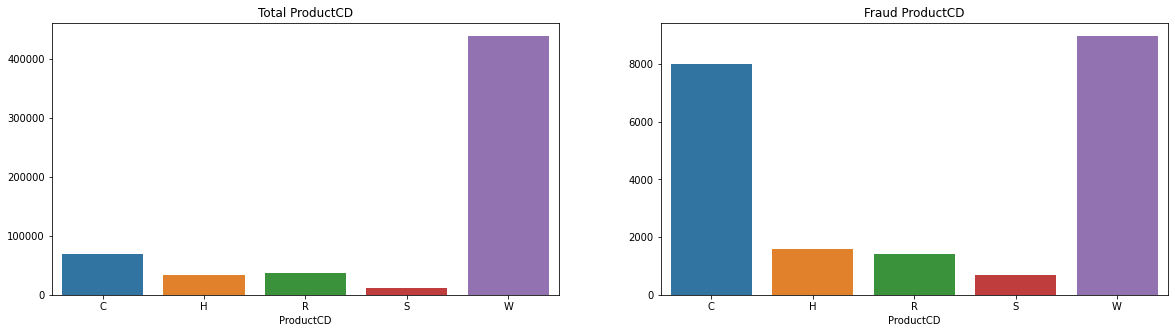

In [133]:
f, axes = plt.subplots(1, 2, figsize=(20,5))

productcd_size = train.groupby('ProductCD').size()
productcd_fraud_size = train.loc[train['isFraud'] == 1].groupby(['ProductCD']).size()

sns.barplot(x=productcd_size.index, y=productcd_size.values, ax=axes[0])
sns.barplot(x=productcd_fraud_size.index, y=productcd_fraud_size.values, ax=axes[1])
axes[0].set_title('Total ProductCD')
axes[1].set_title('Fraud ProductCD')

In [142]:
productcd_size = pd.DataFrame(productcd_size)
totalcd = productcd_size[0].sum()
productcd_size['Percentage'] = (productcd_size[0] / totalcd)*100
print(productcd_size)

                0  Percentage
ProductCD                    
C           68519   11.602770
H           33024    5.592170
R           37699    6.383818
S           11628    1.969045
W          439670   74.452196


In [143]:
productcd_fraud_size = pd.DataFrame(productcd_fraud_size)
totalcd_fraud = productcd_fraud_size[0].sum()
productcd_fraud_size['Percentage'] = (productcd_fraud_size[0] / totalcd_fraud)*100
print(productcd_fraud_size)

              0  Percentage
ProductCD                  
C          8008   38.755263
H          1574    7.617481
R          1426    6.901224
S           686    3.319944
W          8969   43.406088


Text(0.5, 1.0, 'Log size of ProductCD')

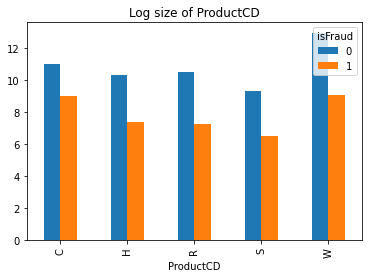

In [112]:
productcd_fraud = train.groupby(['ProductCD', 'isFraud']).size().unstack()
#sns.barplot(x=productcd_fraud_size.index, y=productcd_fraud_size.values)
productcd_fraud[0] = np.log(productcd_fraud[0])
productcd_fraud[1] = np.log(productcd_fraud[1])
productcd_fraud.plot(kind='bar')
plt.title('Log size of ProductCD')

C and W are the most common fraud cases. W is the most common overall ProductCD so it makes sense that it will also be a common fraud case. C only accounts for 11% of the total ProductCD, but it accounts for around 40% of the total fraud cases.

### Card Feature

Card1-Card6 (part of the transactions data)

In [145]:
card_features = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
train[card_features].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


All of these feautres identify the card information that is used for the transaction

***Debit vs Credit***

Text(0.5, 1.0, 'Fraud Card6')

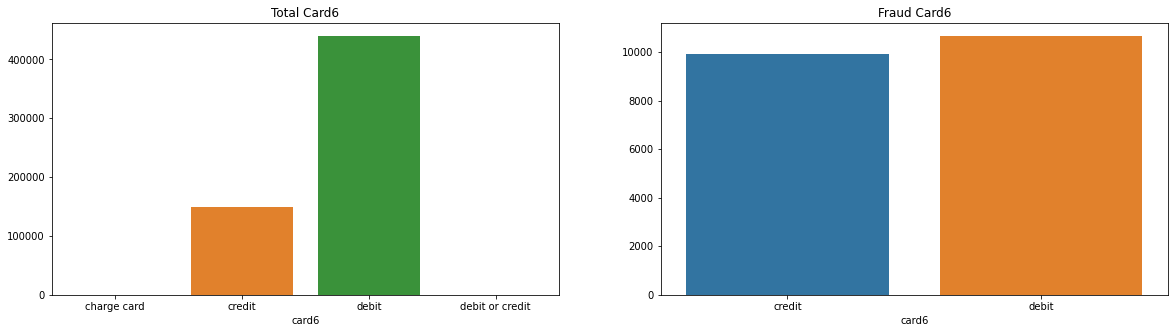

In [150]:
f, axes = plt.subplots(1, 2, figsize=(20,5))

card6_size = train.groupby('card6').size()
card6_fraud_size = train.loc[train['isFraud']==1].groupby('card6').size()

sns.barplot(x=card6_size.index, y=card6_size.values, ax=axes[0])
sns.barplot(x=card6_fraud_size.index, y=card6_fraud_size.values, ax=axes[1])

axes[0].set_title('Total Card6')
axes[1].set_title('Fraud Card6')

***Card Company***

Text(0.5, 1.0, 'Fraud Card4')

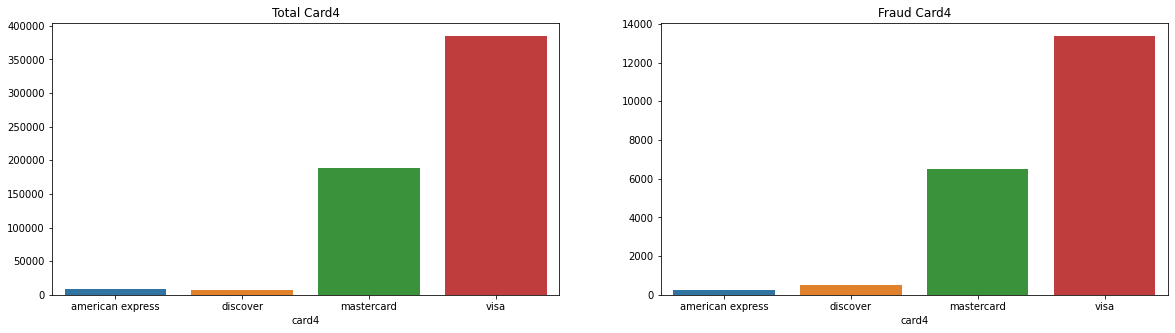

In [152]:
f, axes = plt.subplots(1, 2, figsize=(20,5))

card4_size = train.groupby('card4').size()
card4_fraud_size = train.loc[train['isFraud']==1].groupby('card4').size()

sns.barplot(x=card4_size.index, y=card4_size.values, ax=axes[0])
sns.barplot(x=card4_fraud_size.index, y=card4_fraud_size.values, ax=axes[1])

axes[0].set_title('Total Card4')
axes[1].set_title('Fraud Card4')

***Card 1, 2, 3, and 5 Distributions***

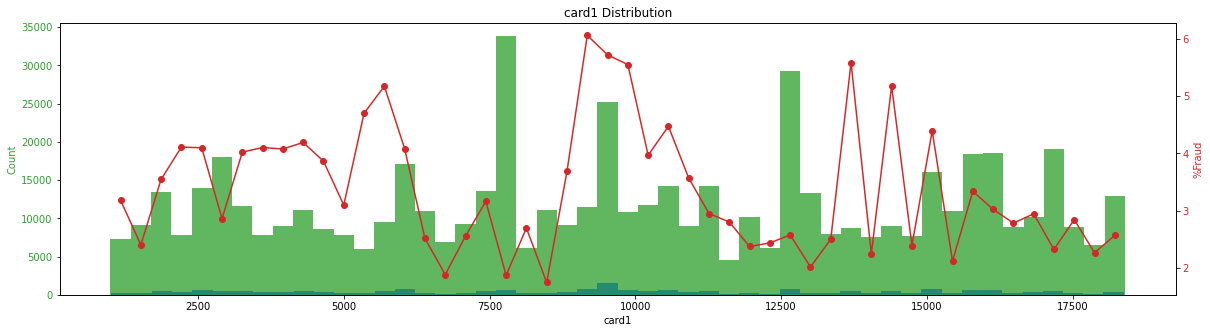

In [341]:
distribution_fraud_percent(train, 'card1', bins=50)

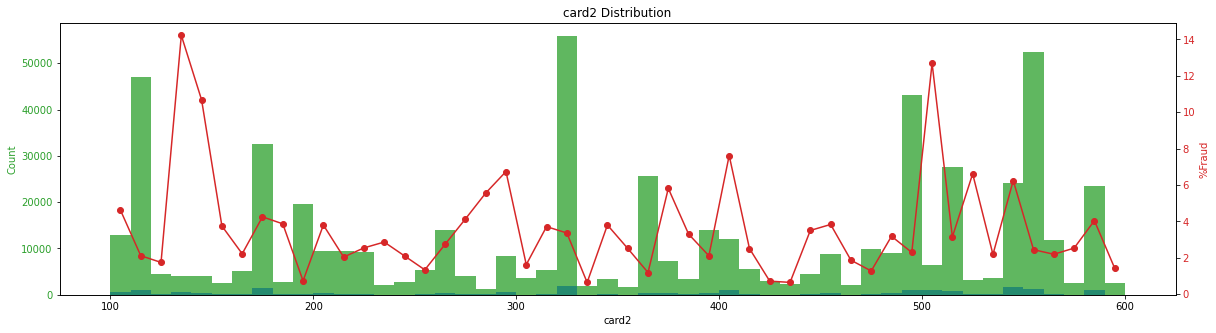

In [246]:
distribution_fraud_percent(train, 'card2', bins=50)

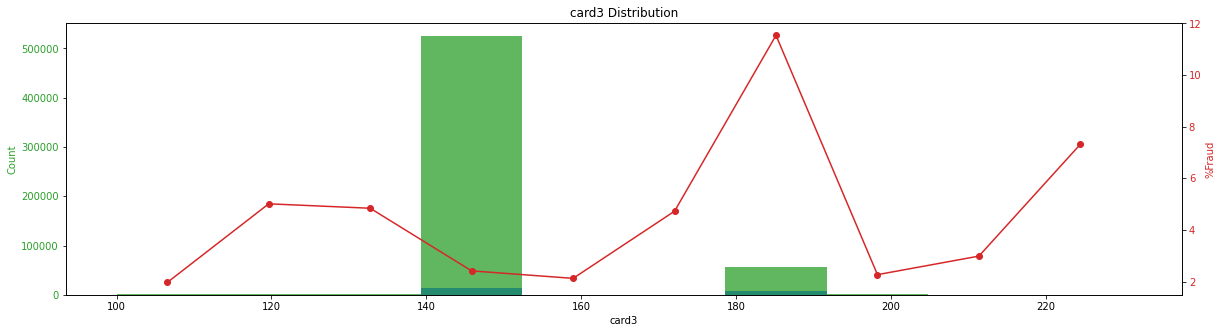

In [244]:
distribution_fraud_percent(train, 'card3', bins=10)

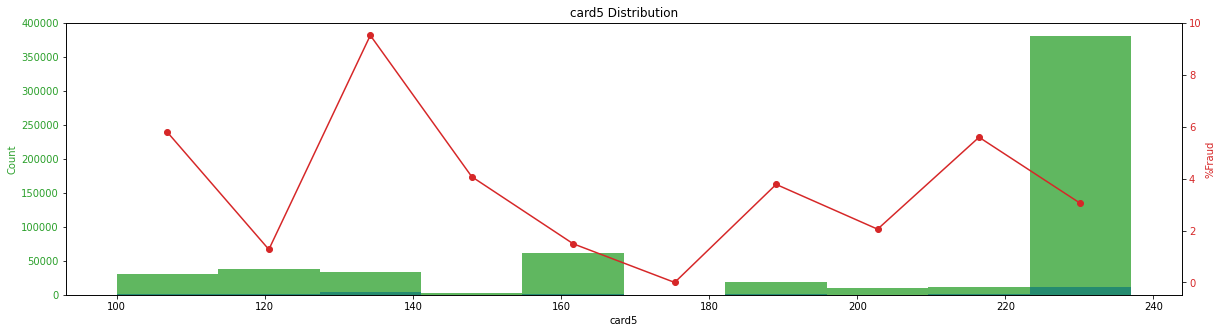

In [243]:
distribution_fraud_percent(train, 'card5', bins=10)

### Addr Feature

In [174]:
addr_features = ['addr1', 'addr2']
train[addr_features].head()

,addr1,addr2
0,315.0,87.0
1,325.0,87.0
2,330.0,87.0
3,476.0,87.0
4,420.0,87.0


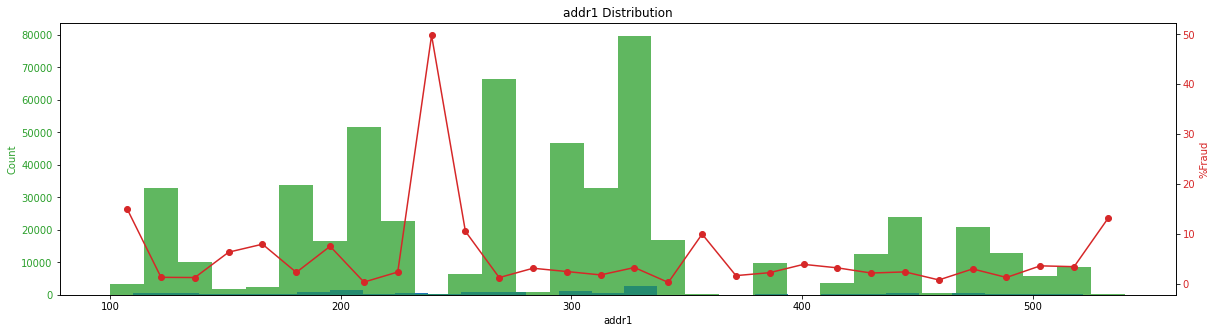

In [249]:
distribution_fraud_percent(train, 'addr1', bins=30)

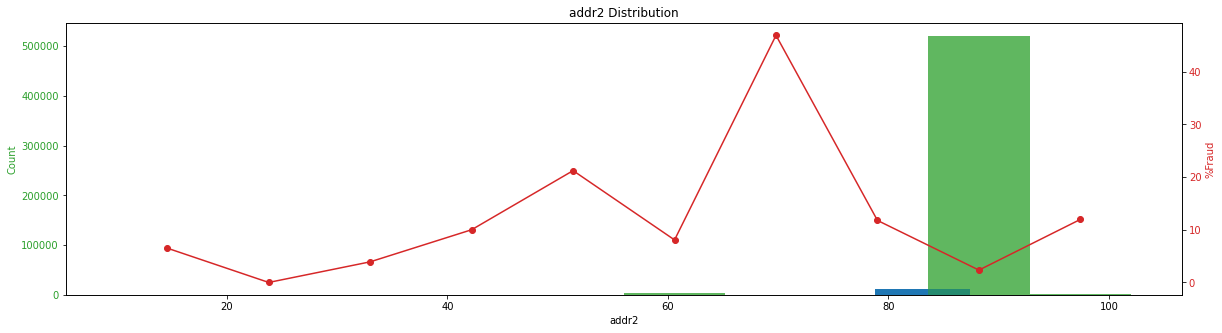

In [253]:
distribution_fraud_percent(train, 'addr2', bins=10)

### Email Domain Feature

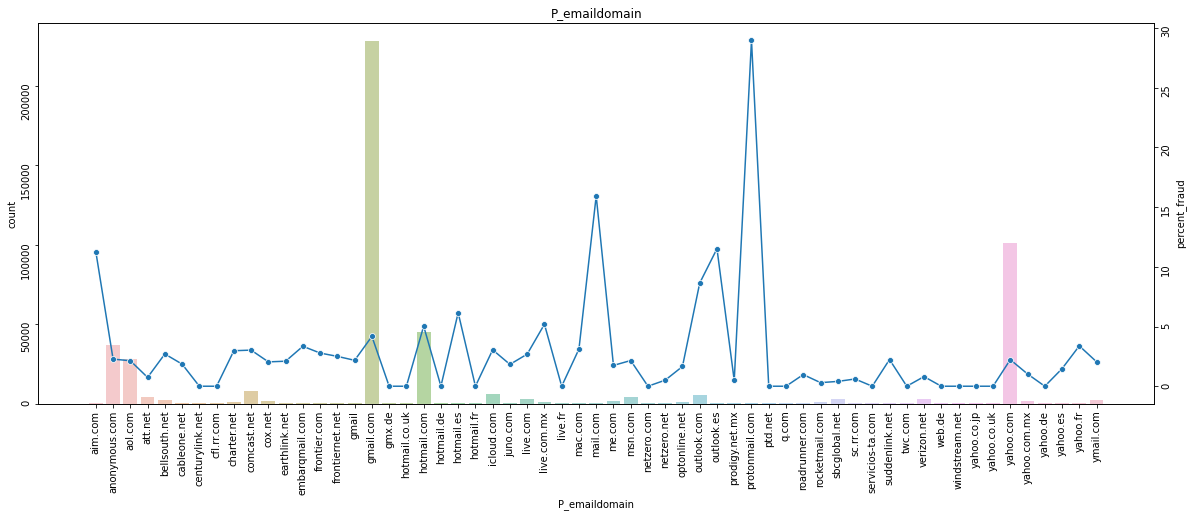

In [372]:
cat_fraud_percent(train, 'P_emaildomain')

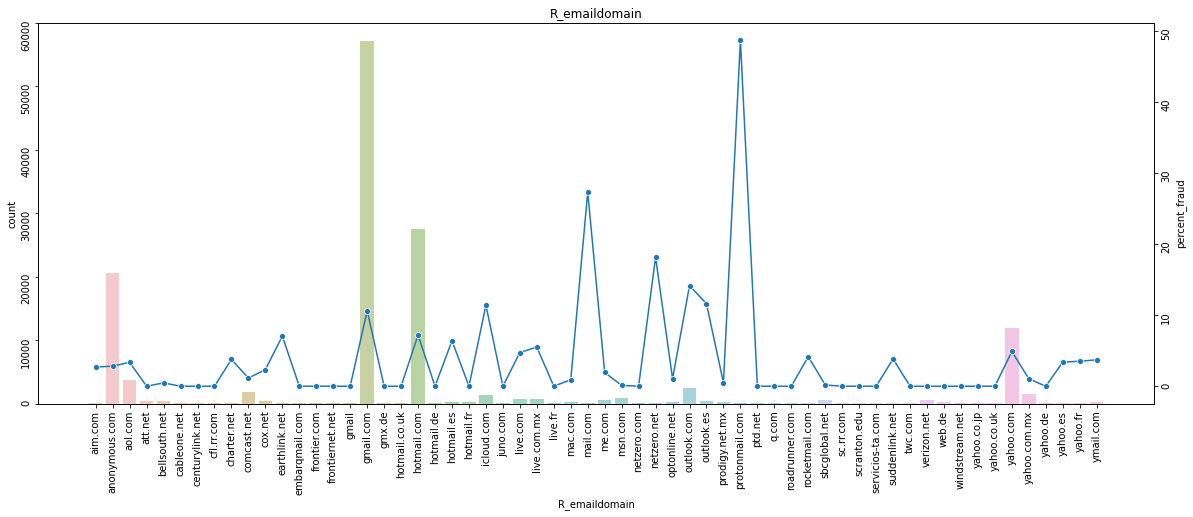

In [371]:
cat_fraud_percent(train, 'R_emaildomain')

### Device Feature

In [350]:
device_feature = ['DeviceType', 'DeviceInfo']
train[device_feature].head()

,DeviceType,DeviceInfo
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,mobile,SAMSUNG SM-G892A Build/NRD90M


In [366]:
train.groupby('DeviceType', dropna=False).size()

DeviceType
desktop     85165
mobile      55645
NaN        449730
dtype: int64

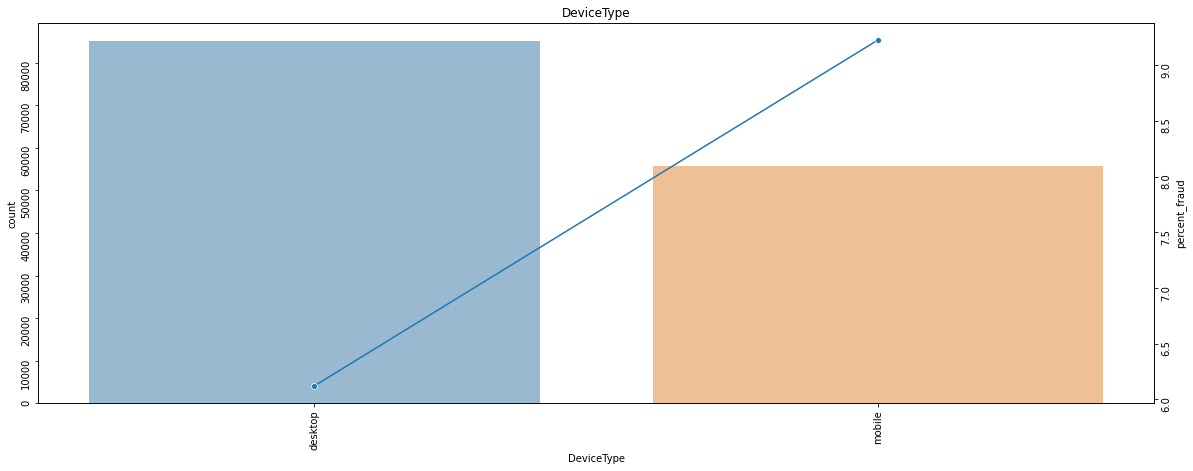

In [370]:
cat_fraud_percent(train, 'DeviceType')

In [392]:
deviceinfo_size = pd.DataFrame(train.groupby('DeviceInfo', dropna=False).size())
deviceinfo_size = deviceinfo_size.sort_values(0, ascending=False)[:10]
deviceinfo_size = deviceinfo_size.rename(columns={0: 'count'})
deviceinfo_size
train.loc[train['DeviceInfo'].isin(['Windows', 'iOS Device'])]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,log_trans_amt
8,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,2.708050
10,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,NaN,NaN,NaN,F,F,T,T,desktop,Windows,4.329245
17,2987017,0,86668,100.000,H,11492,111.0,150.0,mastercard,219.0,...,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows,4.605170
40,2987040,0,87209,75.887,C,13329,569.0,117.0,visa,226.0,...,NaN,NaN,NaN,F,F,T,T,desktop,Windows,4.329245
48,2987048,0,87317,42.294,C,15885,545.0,185.0,visa,138.0,...,NaN,NaN,NaN,F,F,T,T,desktop,Windows,3.744645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590476,3577476,0,15809901,58.512,C,3154,408.0,185.0,mastercard,224.0,...,NaN,NaN,NaN,F,F,T,F,desktop,Windows,4.069232
590478,3577478,0,15809945,24.422,C,6019,583.0,150.0,visa,226.0,...,NaN,NaN,NaN,F,F,T,F,desktop,Windows,3.195484
590495,3577495,0,15810221,100.000,H,9749,181.0,150.0,visa,226.0,...,24.0,1280x1024,match_status:2,T,F,T,T,desktop,Windows,4.605170
590499,3577499,0,15810276,58.512,C,14260,500.0,185.0,mastercard,224.0,...,NaN,NaN,NaN,F,F,T,F,desktop,Windows,4.069232


### ID Feature

## Feature Engineering

In [395]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

train["Date"] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

train['Weekdays'] = train['Date'].dt.dayofweek
train['Hours'] = train['Date'].dt.hour
train['Days'] = train['Date'].dt.day

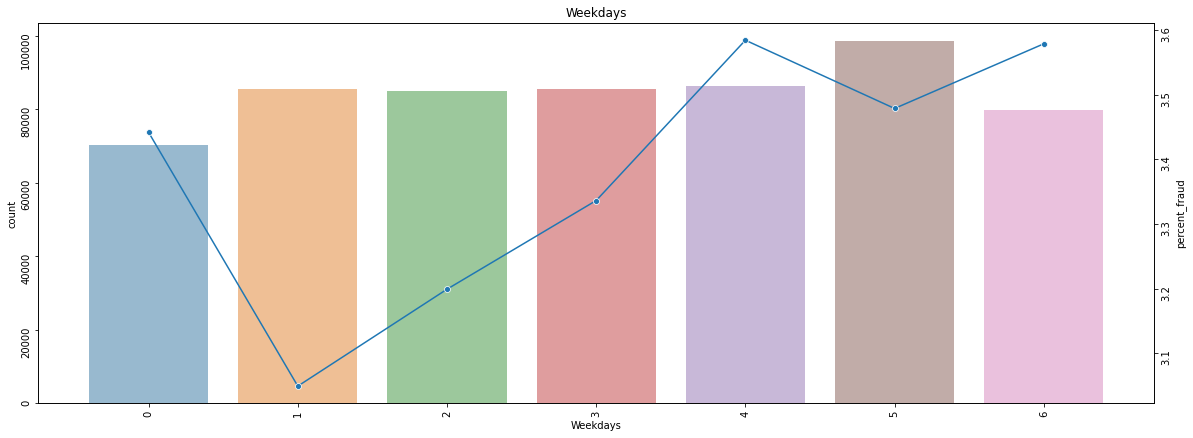

In [407]:
cat_fraud_percent(train, 'Weekdays')

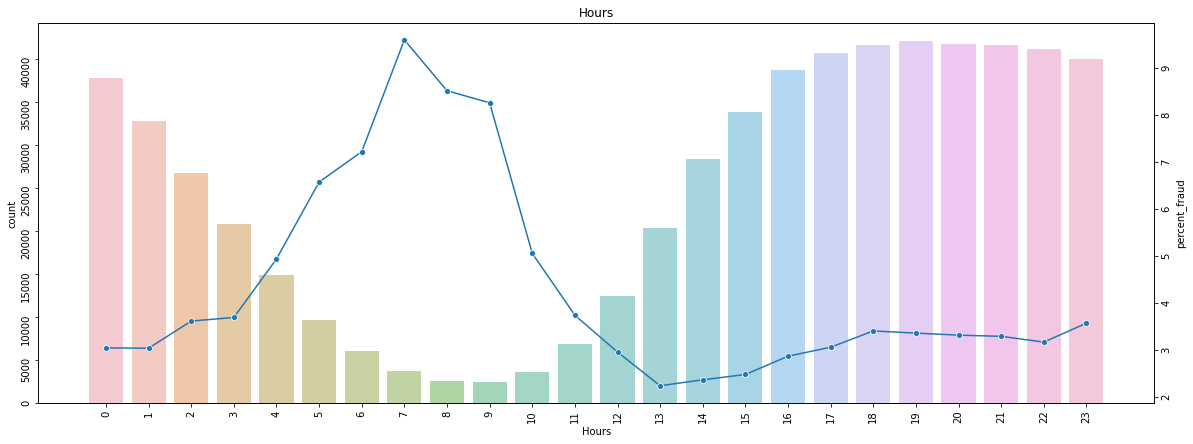

In [408]:
cat_fraud_percent(train, 'Hours')

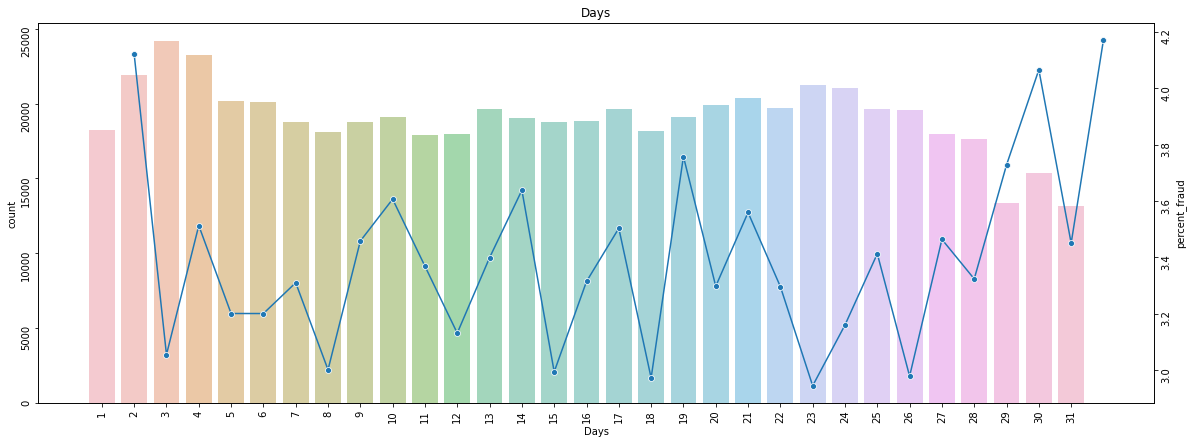

In [412]:
cat_fraud_percent(train, 'Days')